# RNAseq PCA

Notebook for performing PCA on the feature count files.

2020-09-14

## Initial boilerplate

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from os.path import join, dirname, basename, exists, isdir

### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
    pass
else:
    pass
    #mount network drive here

# set up directory paths
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory

RESULTS = join(PROJ, 'results') # output directory
FIGURES = join(RESULTS, 'figures') # figure output directory
PICTURES = join(RESULTS, 'pictures') # picture output directory


# make folders specific for certain data
folder_name = ''
if folder_name != '':
    #make folders if they don't exist
    if not exists(join(RAW_EXTERNAL, folder_name)):
        os.makedirs(join(RAW_EXTERNAL, folder_name))

    if not exists(join(INTERMEDIATE, folder_name)):
        os.makedirs(join(INTERMEDIATE, folder_name))

    if not exists(join(FINAL, folder_name)):
        os.makedirs(join(FINAL, folder_name))

print('Standard variables loaded, you are good to go!')

Python-dotenv could not parse statement starting at line 1


Standard variables loaded, you are good to go!


## 1. Loading data

We load the outputs from featureCounts:

In [2]:
import pandas as pd

data_file_names = []
data_file_names.append("featureCounts_on_Control1.tabular")
data_file_names.append("featureCounts_on_Control4.tabular")
data_file_names.append("featureCounts_on_Control5.tabular")
data_file_names.append("featureCounts_on_KCl2.tabular")
data_file_names.append("featureCounts_on_KCl3.tabular")
data_file_names.append("featureCounts_on_KCl4.tabular")
data_file_names.append("featureCounts_on_NaCl1.tabular")
data_file_names.append("featureCounts_on_NaCl2.tabular")
data_file_names.append("featureCounts_on_NaCl3.tabular")

feature_counts = pd.DataFrame()
for data_file_name in data_file_names:
    full_name = join(INTERMEDIATE,data_file_name)
    new_data = pd.read_csv(full_name, index_col=0, sep="\t")
    new_data.columns = [new_data.columns[0].replace("RNA STAR on ","").replace(": mapped.bam","")]
    if feature_counts.empty:
        feature_counts = new_data
    else:
        feature_counts = pd.merge(feature_counts, new_data, left_index=True, right_index=True)
feature_counts

,Control1,Control4,Control5,1MKCl2,1MKCl3,1MKCl4,1MNaCl1,1MNaCl2,1MNaCl3
Geneid,,,,,,,,,
gene-DEHA2A00110g,172,557,487,44,71,18,85,75,72
gene-DEHA2A00132g,54,227,188,30,30,17,54,53,44
gene-DEHA2A00154g,17157,20856,19692,17471,24301,10478,19806,20211,16215
gene-DEHA2A00176g,107,143,97,94,102,99,86,75,99
gene-DEHA2A00198g,284,417,431,351,519,392,584,506,521
...,...,...,...,...,...,...,...,...,...
rna-NC_010166.1:25973..26055,0,0,0,0,0,0,0,0,0
rna-NC_010166.1:26058..26137,0,0,0,0,0,0,0,0,0
rna-NC_010166.1:27648..27719,0,0,0,0,0,0,0,0,0


## 2. PCA

We will implement a PCA function that can be called several times later:

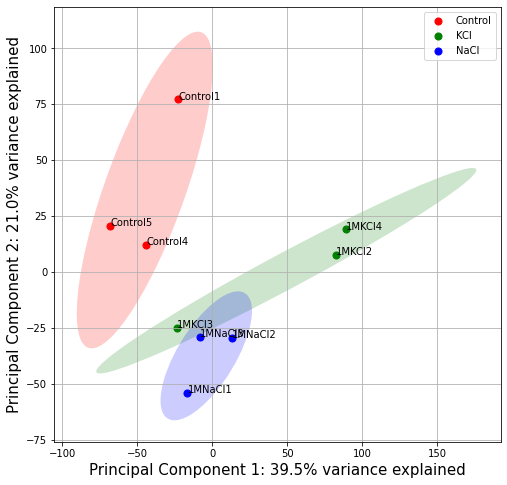

In [3]:
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# function for running and plotting a PCA:
def plot_PCA(feature_counts):

    # transpose data (variables should be the genes)
    feature_counts = feature_counts.transpose()

    # normalize the data:
    x = feature_counts.loc[:, ].values
    x = StandardScaler().fit_transform(x)

    # run PCA:
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)

    #transform PCA results to dataframe
    pca_df = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
    pca_df.index = feature_counts.index
    groups = ["Control", "KCl", "NaCl"]
    for (idx, row) in pca_df.iterrows():
        for group in groups:
            if group in idx:
                pca_df.loc[idx,"group"] = group

    # get % of variability from each component
    exp_var_1 = round(pca.explained_variance_ratio_[0]*100, 1)
    exp_var_2 = round(pca.explained_variance_ratio_[1]*100, 1)

    # plot results
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel(f'Principal Component 1: {exp_var_1}% variance explained', fontsize = 15)
    ax.set_ylabel(f'Principal Component 2: {exp_var_2}% variance explained', fontsize = 15)
    colors = ["r","g","b"]  # RGB
    for group, color in zip(groups,colors):
        to_keep = pca_df['group'] == group
        x = pca_df.loc[to_keep, 'PC1']
        y = pca_df.loc[to_keep, 'PC2']
        ax.scatter(x, y, c=color, s=50)
        confidence_ellipse(x, y, ax, n_std=2, edgecolor="none", facecolor=color, alpha=0.2, label='_nolegend_')
    ax.legend(groups)
    for (idx, row) in pca_df.iterrows():
        ax.text(row["PC1"], row["PC2"], idx)
    ax.grid()

plot_PCA(feature_counts)

## 3. Effect of data normalization

We will transform the read counts to Transcripts Per Kilobase Million (TPM), by first converting the read counts to reads per kilobase (RPK), i.e. normalizing by gene length (in kilobase):

In [4]:
# load gene length data
import csv
with open(join(RAW_EXTERNAL,"gene_length.tabular"), mode='r') as infile:
    reader = csv.reader(infile, delimiter="\t")
    gene_length = {rows[0]:int(rows[1])/1000 for rows in reader}  # we divide by 1000 to get kilobase

# normalize by gene length
to_delete = []
for (idx, row) in feature_counts.iterrows():
    try:
        gene_id = idx.replace("gene-", "")
        feature_counts.loc[idx, :] = row/gene_length[gene_id]
    except:
        print(f"Could not match {idx}")
        to_delete.append(idx)

# drop rows without gene length (i.e. not available in the reference genome)
feature_counts = feature_counts.drop(to_delete)
feature_counts

Could not match gene-DEHA2A07898r
Could not match gene-DEHA2B02662r
Could not match gene-DEHA2C09790r
Could not match gene-DEHA2D10846r
Could not match gene-DEHA2D15774r
Could not match gene-DEHA2D16852r
Could not match gene-DEHA2E15818r
Could not match gene-DEHA2F21296r
Could not match gene-DEHA2G09746r
Could not match rna-NC_010166.1:2480..2551
Could not match rna-NC_010166.1:3329..3399
Could not match rna-NC_010166.1:12797..12867
Could not match rna-NC_010166.1:13006..13077
Could not match rna-NC_010166.1:13228..13308
Could not match rna-NC_010166.1:13310..13381
Could not match rna-NC_010166.1:13444..13515
Could not match rna-NC_010166.1:14490..14560
Could not match rna-NC_010166.1:14558..14630
Could not match rna-NC_010166.1:14642..14714
Could not match rna-NC_010166.1:14714..14794
Could not match rna-NC_010166.1:14799..14870
Could not match rna-NC_010166.1:18498..18570
Could not match rna-NC_010166.1:18652..18722
Could not match rna-NC_010166.1:18772..18843
Could not match rna-NC_

,Control1,Control4,Control5,1MKCl2,1MKCl3,1MKCl4,1MNaCl1,1MNaCl2,1MNaCl3
Geneid,,,,,,,,,
gene-DEHA2A00110g,40.690797,131.771942,115.211734,10.409274,16.796783,4.258339,20.108824,17.743080,17.033357
gene-DEHA2A00132g,44.117647,185.457516,153.594771,24.509804,24.509804,13.888889,44.117647,43.300654,35.947712
gene-DEHA2A00154g,16481.268012,20034.582133,18916.426513,16782.901057,23343.900096,10065.321806,19025.936599,19414.985591,15576.368876
gene-DEHA2A00176g,502.347418,671.361502,455.399061,441.314554,478.873239,464.788732,403.755869,352.112676,464.788732
gene-DEHA2A00198g,868.501529,1275.229358,1318.042813,1073.394495,1587.155963,1198.776758,1785.932722,1547.400612,1593.272171
...,...,...,...,...,...,...,...,...,...
gene-DEHA2G25080g,4.115226,0.000000,8.230453,41.152263,8.230453,4.115226,32.921811,8.230453,24.691358
gene-DEHA2G25102g,7.017544,9.356725,12.865497,21.052632,22.222222,16.374269,25.730994,25.730994,19.883041
gene-DEHA2G25124g,50.980392,17.647059,23.529412,23.529412,56.862745,54.901961,174.509804,15.686275,300.000000


Let's see if the PCA changes:

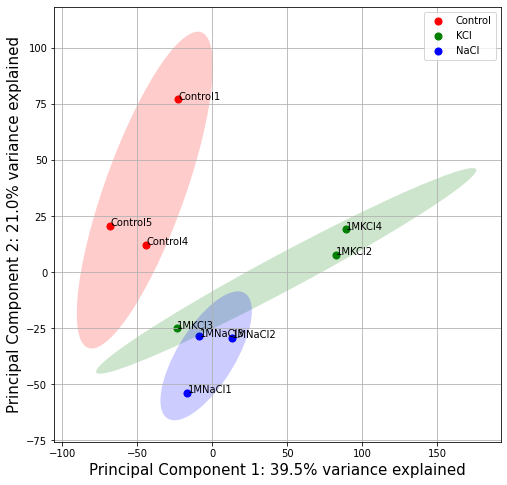

In [5]:
plot_PCA(feature_counts)

Nothing changes, as the scaling performed is by variable, which PCA normalizes later for anyways.

Now let's transform from RPK to TPM by dividing all columns by sample size. This way we account by sequencing depth:

In [6]:
scaling_factor = feature_counts.sum(axis=0)/1000000  # per million scaling factor
scaling_factor

Control1    27.666441
Control4    31.924912
Control5    28.355159
1MKCl2      32.990316
1MKCl3      32.662568
1MKCl4      34.811806
1MNaCl1     35.527188
1MNaCl2     31.420586
1MNaCl3     30.650691
dtype: float64

In [7]:
for (column_name, column) in feature_counts.iteritems():
    feature_counts[column_name] = column/scaling_factor[column_name]
feature_counts

,Control1,Control4,Control5,1MKCl2,1MKCl3,1MKCl4,1MNaCl1,1MNaCl2,1MNaCl3
Geneid,,,,,,,,,
gene-DEHA2A00110g,1.470764,4.127559,4.063167,0.315525,0.514252,0.122325,0.566012,0.564696,0.555725
gene-DEHA2A00132g,1.594627,5.809179,5.416819,0.742939,0.750394,0.398971,1.241800,1.378098,1.172819
gene-DEHA2A00154g,595.713341,627.553248,667.124696,508.722053,714.698860,289.135297,535.531738,617.906534,508.189816
gene-DEHA2A00176g,18.157284,21.029393,16.060537,13.377094,14.661224,13.351469,11.364701,11.206432,15.164054
gene-DEHA2A00198g,31.391878,39.944648,46.483352,32.536654,48.592504,34.435926,50.269465,49.247987,51.981607
...,...,...,...,...,...,...,...,...,...
gene-DEHA2G25080g,0.148744,0.000000,0.290263,1.247404,0.251984,0.118214,0.926665,0.261945,0.805573
gene-DEHA2G25102g,0.253648,0.293085,0.453727,0.638146,0.680357,0.470365,0.724262,0.818922,0.648698
gene-DEHA2G25124g,1.842680,0.552768,0.829811,0.713222,1.740915,1.577108,4.912007,0.499236,9.787708


We can confirm the normalization is working as expected by checking the sum of each sample:

In [8]:
feature_counts.sum(axis=0)

Control1    1000000.0
Control4    1000000.0
Control5    1000000.0
1MKCl2      1000000.0
1MKCl3      1000000.0
1MKCl4      1000000.0
1MNaCl1     1000000.0
1MNaCl2     1000000.0
1MNaCl3     1000000.0
dtype: float64

We can now repeat yet again the PCA:

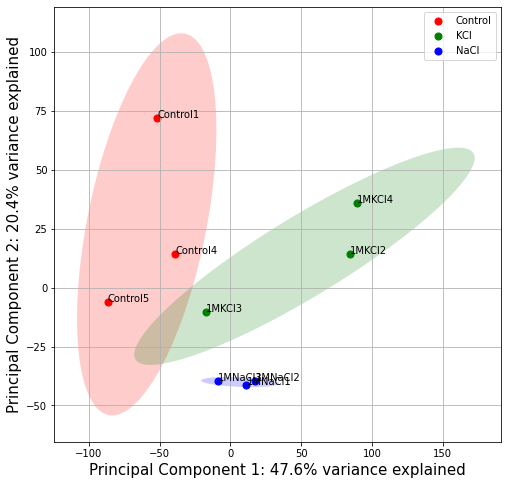

In [9]:
plot_PCA(feature_counts)

The separation works much better, with clearer groups and the explained variance going up from 60.5% to 68%.